# About

The objective of this study is to create a model capable of separating customer credit card accounts that have fallen into delinquency from those that have not. Our data set is comprised of their monthly customer profile. Per Kaggle, the purveyor of the data, "the target binary variable is calculated by observing 18 months performance window after the latest credit card statement . . . . if the customer does not pay [the amount due] 120 days after their latest statement date it is considered a default event."

The data set contains customer-level statement information. Features are anonymized, normalized, and fall into the following general categories:

D_* = Delinquency variables, S_* = Spend variables, P_* = Payment variables, B_* = Balance variables, R_* = Risk variables. 

The following features are categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Our task is to predict, for each customer_ID, the probability of future payment default (target = 1).

Source(https://www.kaggle.com/competitions/amex-default-prediction/data?select=train_labels.csv)

# 1.0 Imports

If you read our Pricing Analytics study, you will have seen the typical data science tech stack used extensively. Here, a considerable amount of our modeling will ultimately rely on [PyCaret](https://pycaret.org/), an industry standard. Running the notebok requires importing PyCaret from outside of the Colab environment (i.e., the environment in which this study was first conceived). To load and enable PyCaret, run the following cell and then restart the notebook runtime.

In [1]:
!pip install --pre pycaret --quiet
!pip install matplotlib==3.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.3/504.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 86.4 MB/s eta 0:0

We import the standard data science packages in the following cell. Note that PyCaret import its preferred version of a number of common packages -- including numpy -- automatically.

In [1]:
from statsmodels import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 2.0 Data Acquisition

Initially, we used pip and a wide array of command-line statements to import four csv files into our environment. This approach was needlessly time consuming; thirty minutes to execute a simple data transfer is a bridge too far.

The code below brings our data into the Colab environment. The original files contained 10 million observations. Having so much information at our disposal would be a delight. We are, however, capacity constrained. Hence, we use only 10% of the data provided in the source files. This is a limitation of the study.

In [82]:
train_labels = pd.read_csv('/content/drive/MyDrive/Amex/train_labels.csv', chunksize=10000)
train_set = pd.read_csv('/content/drive/MyDrive/Amex/train_data.csv', chunksize=10000)
sample_submission = pd.read_csv('/content/drive/MyDrive/Amex/sample_submission.csv', chunksize=10000)
test_set = pd.read_csv('/content/drive/MyDrive/Amex/test_data.csv', nrows=10000)

Our design matrix (i.e., training set) and target labels are provided in separate files. Here, we merge them together and add a an extra column for our convenience.

In [83]:
df = pd.DataFrame()
for chunk, target in zip(train_set, train_labels):
  merger = chunk.merge(target, how='inner', on='customer_ID')
  merger['Count'] = 1
  df = df.append(merger, ignore_index=True)
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,Count
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0,1
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0,1
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0,1
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0,1
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0,1


# 3.0 Exploratory Data Analysis

The next two cells provide us with a global view of our data set.

In [84]:
print(f'We have {len(df.columns)} features in our data set (including the target and our count columns) and {df.shape[0]} observations.')

We have 192 features in our data set (including the target and our count columns) and 10000 observations.


In [85]:
print(df.dtypes[:25])

customer_ID     object
S_2             object
P_2            float64
D_39           float64
B_1            float64
B_2            float64
R_1            float64
S_3            float64
D_41           float64
B_3            float64
D_42           float64
D_43           float64
D_44           float64
B_4            float64
D_45           float64
B_5            float64
R_2            float64
D_46           float64
D_47           float64
D_48           float64
D_49           float64
B_6            float64
B_7            float64
B_8            float64
D_50           float64
dtype: object


Our data look quite different when grouped.

In [86]:
print(f'There are {len(df["customer_ID"].unique())} unique customers in our data set versus {len(df)} individual observations.\nThis suggests the data contain multiple transactions per customer.')

There are 826 unique customers in our data set versus 10000 individual observations.
This suggests the data contain multiple transactions per customer.


In [87]:
df.groupby('customer_ID')['Count'].agg('sum').describe()

count    826.000000
mean      12.106538
std        2.520852
min        1.000000
25%       13.000000
50%       13.000000
75%       13.000000
max       13.000000
Name: Count, dtype: float64

The above results are unexpected. The mean and median (marked '50%') are nearly the same. Furthermore, the same number characterizes the entire interquartile range.  This is either quite a coincidence or evidence that our data are manufactured.

As demonstrated by the graph below, a maximum of 13 observations were taken from a large number customers, while fewer than 13 transactions were collected in a minority of cases. Consequently, it seems likely the unusual summary statistics are the result of human intervention.

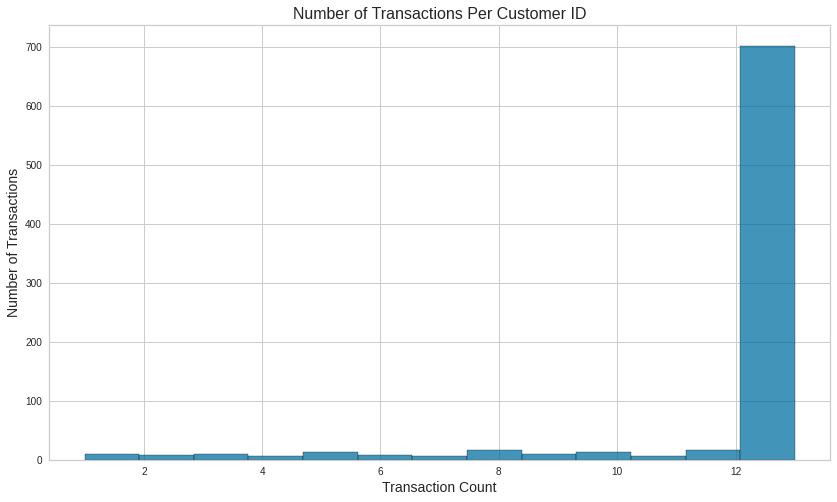

In [88]:
group_obj = df.groupby(['customer_ID'])['Count'].sum().reset_index()
plt.figure(figsize = (14,8))
sns.histplot(data = group_obj, x = 'Count', bins=13)
plt.ylabel("Number of Transactions", size=14)
plt.xlabel("Transaction Count", size=14)
plt.title("Number of Transactions Per Customer ID", size=16);

Classification problems are typified by an imbalance between the positive and negative classes. There are fewer positive cases in our study than there are instances of the negative case. 

Represented by a '1' in our target column, our positive case is 'delinquency,' an admittedly negative event. Our negative case, represented by a '0' by in the target column, indicates a customer account up-to-date. Below, we explore the distribution between the positive and negative classes. 

In [89]:
class_distribution = df.target.value_counts()
print(f'Approximately {round(class_distribution[1]/class_distribution[0],2)*100}% of observations are in the positive (delinquent) class.')
class_distribution

Approximately 34.0% of observations are in the positive (delinquent) class.


0    7447
1    2553
Name: target, dtype: int64

Features with cases missing data are commonplace in business. In the cell below, we calculate that, on average, our features are missing just over 15% of their data.

In [90]:
missing = round(((df.isna().sum())/len(df)),2) * 100
avg = round(((df.isna().sum())/len(df)),2)* 100
print(f'The mean percentage of missing values is {round(avg.mean(), 2)}%.')

The mean percentage of missing values is 15.03%.


All columns (features) are not equally informative. Here, we narrow the feature space to include only the most informative columns. Using our average percentage missing as a guide, we keep only those columns with at least 15% of their data and dispense with all other columns, including `customer ID`.

In [91]:
# the threshold is the percentage missing above which we no longer wish to consider the feature
threshold = .15
df = df.copy(deep=True)
df = df.loc[:, df.isnull().mean() < threshold]
df.drop('customer_ID', axis=1, inplace=True)
train_columns = list(df.columns)

The feature space of our training set must match the feature space of our test set. We accomplish this by taking the set intersection of the features in our training set.

In [92]:
test_set.drop('customer_ID', axis=1, inplace=True)
test_columns = list(test_set)
cols_to_keep = set(test_columns).intersection(set(train_columns))

The set intersection above provides us with the names of the features with which we will work. Below, we make the actual modifications to our data sets by keeping only the columns we've selected.

In [93]:
test_modified = test_set[list(cols_to_keep)]
target = df['target']
train_modified = df[list(cols_to_keep)]

Here, we ensure that our target column is attached to our new training data frame.

In [94]:
train_modified2 = pd.concat([train_modified, pd.DataFrame(target)], axis="columns")

To avoid copy modification errors and seamlessly proceed to feature engineering, we make deep copies of both data frames and introduce a change of variable.

In [95]:
train = train_modified2.copy(deep=True)
test = test_modified.copy(deep=True)

#4.0 Feature Engineering

Our dataframes contain date data. This can be mined for the month, the number of the day during the month, and the day of the week for which it stands. Below, we extract this information for future use.

In [99]:
train['S_2'] = train['S_2'].astype('datetime64[ns]')
train['month'] = train['S_2'].dt.month
train['day'] = train['S_2'].dt.day
train['weekday'] = train['S_2'].dt.day_name()
train.drop(['S_2'], axis=1, inplace=True)

In [100]:
test['S_2'] = test['S_2'].astype('datetime64[ns]')
test['month'] = test['S_2'].dt.month
test['day'] = test['S_2'].dt.day
test['weekday'] = test['S_2'].dt.day_name()
test.drop(['S_2'], axis=1, inplace=True)

For the curious, the new date information vectors are now appended to our data sets, as shown in the cells to the far right.

In [101]:
train.loc[:,'D_145':].head()

,D_145,D_126,B_10,D_83,R_15,D_75,B_30,R_17,R_21,D_89,...,R_25,S_13,D_133,S_15,D_96,D_51,target,month,day,weekday
0,0.002674,1.0,0.096219,0.007043,0.006452,0.069067,0.0,0.000198,0.002450,0.002665,...,0.003647,0.515222,0.004345,0.108271,0.004950,1.335856,0,3,9,Thursday
1,0.009217,1.0,0.099804,0.007789,0.002332,0.074166,0.0,0.001142,0.002247,0.002508,...,0.008850,0.509048,0.007495,0.101018,0.003180,1.339794,0,4,7,Friday
2,0.002603,1.0,0.134073,0.004093,0.008358,0.076510,0.0,0.008013,0.007794,0.009634,...,0.009769,0.679257,0.009227,0.103239,0.005433,1.337179,0,5,28,Sunday
3,0.009600,1.0,0.134437,0.008817,0.007364,0.071547,0.0,0.009455,0.007686,0.007791,...,0.004858,0.515282,0.007206,0.206394,0.000063,1.339909,0,6,13,Tuesday
4,0.009827,1.0,0.121518,0.001845,0.002470,0.074432,0.0,0.002019,0.009656,0.005158,...,0.002983,0.507712,0.006312,0.106020,0.000535,1.341735,0,7,16,Sunday


In [102]:
test.loc[:,'D_145':].head()

,D_145,D_126,B_10,D_83,R_15,D_75,B_30,R_17,R_21,D_89,...,B_33,R_25,S_13,D_133,S_15,D_96,D_51,month,day,weekday
0,NaN,0.0,-0.002919,NaN,0.004144,0.204590,0.0,0.008908,0.004635,0.006653,...,1.003810,0.008442,0.409411,0.007082,0.400602,0.009575,0.008718,2,19,Tuesday
1,0.001460,0.0,0.031222,NaN,0.002083,0.206570,0.0,0.000843,0.000574,0.004394,...,1.004629,0.006347,0.561424,0.007188,0.605887,0.006952,0.003146,3,25,Monday
2,0.006482,0.0,0.035532,NaN,0.001140,0.204640,0.0,0.000337,0.006438,0.004019,...,1.007063,0.009021,0.692383,0.008436,0.601936,0.003944,0.006082,4,25,Thursday
3,0.007855,0.0,0.043155,NaN,0.006834,0.203464,0.0,0.003653,0.002879,0.003135,...,1.009508,0.000756,0.690850,0.002422,0.508140,0.001333,0.004940,5,20,Monday
4,0.009471,0.0,0.063187,0.001843,0.005148,0.201180,0.0,0.003520,0.000445,0.004443,...,1.001869,0.003849,0.691550,0.000302,0.402430,0.009160,0.003320,6,15,Saturday


We know which columns contain continuous data and which features are categorical. We separate the two here and fill the missing data in continuous columns with each columns' mean. The mean of any relevant training set column is also placed in the empty slots found in that column. This allows us to avoid data leakage.

The cell immmediately below illustrates our work on features containing continuous values.

In [103]:
# fill select columns with mean
revised_columns = cols_to_keep - set(['D_63', 'D_64', 'D_68', 'B_30', 'B_31', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'S_2'])
revised_columns = list(revised_columns)
train[revised_columns] = train[revised_columns].fillna(value=train[revised_columns].mean())
# missing test values replaced with train column means to prevent data leakage
test[revised_columns] = test[revised_columns].fillna(value=train[revised_columns].mean())

Next, we illustrate how we cope with missing categorical data. Specifically, we find the most frequently seen data point in the training set for each categorical vector and use it to fill-in missing data. We execute this procedure on both our training and test sets.

In [104]:
train['D_63'].fillna('CO', inplace=True)
train['D_64'].fillna('O', inplace=True)
train['D_68'].fillna(6, inplace=True)
train['B_30'].fillna(0, inplace=True)
train['B_31'].fillna(1, inplace=True)
train['B_38'].fillna(2, inplace=True)
train['D_114'].fillna(1, inplace=True)
train['D_116'].fillna(0, inplace=True)
train['D_117'].fillna(-1, inplace=True)
train['D_120'].fillna(0, inplace=True)
train['D_126'].fillna(1, inplace=True)
print("Training Set Missing Values Imputed.")
print('\n')
test['D_63'].fillna('CO', inplace=True)
test['D_64'].fillna('O', inplace=True)
test['D_68'].fillna(6, inplace=True)
test['B_30'].fillna(0, inplace=True)
test['B_31'].fillna(1, inplace=True)
test['B_38'].fillna(2, inplace=True)
test['D_114'].fillna(1, inplace=True)
test['D_116'].fillna(0, inplace=True)
test['D_117'].fillna(-1, inplace=True)
test['D_120'].fillna(0, inplace=True)
test['D_126'].fillna(1, inplace=True)
print("Missing values in test set replaced with mean of training set to prevent data leakage.")

Training Set Missing Values Imputed.


Missing values in test set replaced with mean of training set to prevent data leakage.


Both numerical and string data representing categorical information must be transformed to be useful in this context. Below, we import the binary encoder used to perform the transformation. Note, while we typically make a practice of doing all imports at the start of our notebook, issues with loading and working with PyCaret for the first time made this the most logical place to import encoder technology.

In [105]:
%pip install category_encoders --quiet
import category_encoders
from category_encoders import BinaryEncoder

Here, we specify the columns whose encoding we will change, instantiate an encoder for both the training and test sets, and transform our data.

In [106]:
cols = ['D_63', 'D_64', 'D_68', 'B_30', 'B_31', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'month', 'day', 'weekday']
encoder = BinaryEncoder(cols = cols, return_df = True)
train = encoder.fit_transform(train)
train = train.copy(deep=True)

#encoder2 = BinaryEncoder(cols = cols, return_df = True)
test = encoder.fit_transform(test)
test = test.copy(deep = True)

# 5.0 Modeling and Model Testing

PyCaret is designed to automatically do everything we just accomplished manually. This begs the question: Did we just waste our time? The answer is a firm, "no." Using black boxes is horrible practice. Consequently, we've limited our use of PyCaret, restricting it to the modeling phase of our study. PyCaret's modeling capabilities are built on familiar scikit-learn technology. Hence, there are no black boxes, as we have used scikit-learn often in the past.

Though we have a test set, PyCaret splits the data in its own way for training and testing. This is what occurs in the following cell. More importantly, it allows us to use the training set supplied by the Kaggle site as yet another test set. This is a marvelous turn of events because, typically, prototyping involves only one test set, which can cause data leakage issues if the test set is used more than once.

In [107]:
y = train['target']
X_pycaret = train.copy(deep=True)
#X_pycaret = X_pycaret.drop(['Count', 'customer_ID'], axis=1)
data = X_pycaret.sample(frac=0.70, random_state=144).reset_index(drop=True)
data_unseen = X_pycaret.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (7000, 181)
Unseen Data For Predictions: (3000, 181)


In [108]:
data_unseen.head()

,D_52,R_2,B_11,S_16,B_4,S_12,D_48,D_62,P_4,R_6,...,month_2,month_3,day_0,day_1,day_2,day_3,day_4,weekday_0,weekday_1,weekday_2
0,0.398898,0.002515,0.030000,0.003817,0.046623,0.213628,0.086219,0.630733,0.003984,0.000822,...,1,0,1,0,1,0,0,1,1,0
1,0.398679,0.008815,0.044275,0.000141,0.064387,0.206849,0.064676,0.635885,0.003244,0.004779,...,1,1,1,1,0,0,0,1,0,0
2,0.402825,0.007137,0.013518,0.004640,0.052499,0.221441,0.022703,0.629337,0.006916,0.004221,...,0,0,1,1,0,1,1,1,0,0
3,0.400943,0.007976,0.018204,0.003500,0.070618,0.325719,0.021549,0.631458,0.004984,0.007823,...,0,1,1,0,1,1,0,1,1,1
4,0.096993,0.006018,0.005175,0.009030,0.009390,0.187263,0.961863,0.185423,0.958002,0.007629,...,1,0,1,1,0,1,0,1,1,1


This is one of our more exciting lines of code. Here, we setup PyCaret to use our training data and target to try several models that we believe could assist us in addressing our research question. PyCaret will also correct for multicollinearity (+70% correlation) and perform k-fold crossvalidation on our models where k = 3. Typically, we cross-validate on the interval [5, 10], however, we are resource constrained. We use SMOTE to correct the class imbalance given additional resources.

In [109]:
from pycaret.classification import *
s = setup(data = data, target = 'target', remove_multicollinearity=True, fold=3, fix_imbalance = True, session_id=1024)

,Description,Value
0,Session id,1024
1,Target,target
2,Target type,Binary
3,Original data shape,"(7000, 181)"
4,Transformed data shape,"(9424, 169)"
5,Transformed train set shape,"(7324, 169)"
6,Transformed test set shape,"(2100, 169)"
7,Numeric features,180
8,Preprocess,True
9,Imputation type,simple


We received intelligence on 14 different models, after 5 hours of processing time. This run time is unacceptable. To remedy the situation, we did a second run, limiting the number of models considered to the most effective, as well as a `dummy` baseline model.

In [67]:
best = compare_models(sort="Recall", include = ['lightgbm', 'gbc', 'dummy'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9400,0.9828,0.9047,0.8646,0.8841,0.8437,0.8441,1.7267
gbc,Gradient Boosting Classifier,0.9065,0.9649,0.8796,0.7793,0.8264,0.7628,0.7654,7.3067
dummy,Dummy Classifier,0.7473,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5533


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

Let's take a look at the winning model, Light Gradient Boosting Machine, across 5 folds of cross validation.



In [68]:
lgbm = create_model('lightgbm', cross_validation=True, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9367,0.9810,0.8992,0.8577,0.8780,0.8353,0.8357
1,0.9408,0.9852,0.8790,0.8862,0.8826,0.8430,0.8430
2,0.9612,0.9919,0.9556,0.8977,0.9258,0.8996,0.9004
3,0.9469,0.9879,0.9190,0.8764,0.8972,0.8615,0.8619
4,0.9449,0.9849,0.9190,0.8697,0.8937,0.8565,0.8571
Mean,0.9461,0.9862,0.9144,0.8776,0.8955,0.8592,0.8596
Std,0.0083,0.0036,0.0254,0.0137,0.0167,0.0223,0.0224


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [69]:
tuned_lgbm = tune_model(lgbm, optimize='Recall', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8765,0.9544,0.8952,0.7003,0.7858,0.7009,0.7113
1,0.8959,0.9582,0.8831,0.7500,0.8111,0.7399,0.7446
2,0.9112,0.9770,0.9677,0.7524,0.8466,0.7855,0.7978
3,0.8990,0.9665,0.9555,0.7284,0.8266,0.7572,0.7710
4,0.9031,0.9586,0.9312,0.7468,0.8288,0.7623,0.7714
Mean,0.8971,0.9629,0.9265,0.7356,0.8198,0.7492,0.7592
Std,0.0115,0.0081,0.0330,0.0195,0.0204,0.0282,0.0293


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [70]:
tuned_lgbm

LGBMClassifier(bagging_fraction=0.4, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=11, min_child_weight=0.001, min_split_gain=0,
               n_estimators=40, n_jobs=-1, num_leaves=200, objective=None,
               random_state=1024, reg_alpha=0.4, reg_lambda=0.01, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

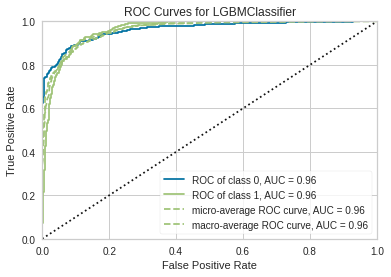

In [71]:
plot_model(tuned_lgbm)

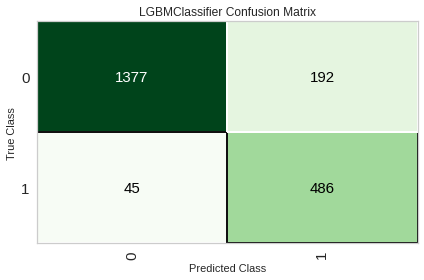

In [72]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

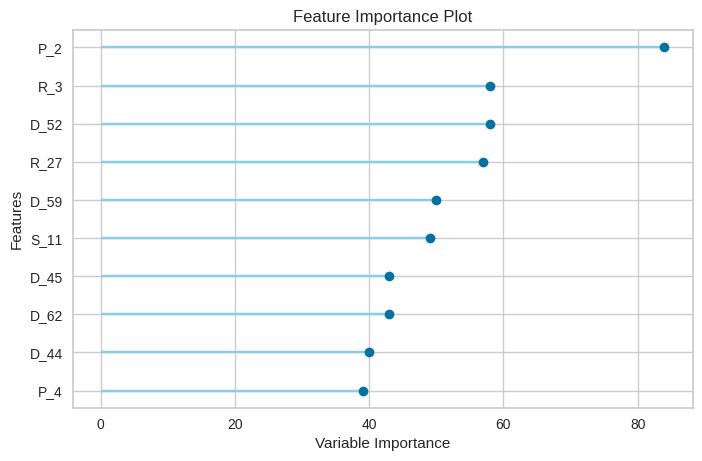

In [73]:
plot_model(tuned_lgbm, plot='feature')

In [74]:
# Make predictions on the test set
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8871,0.9620,0.9153,0.7168,0.8040,0.7264,0.7371


,D_52,R_2,B_11,S_16,B_4,S_12,D_48,D_62,P_4,R_6,...,day_1,day_2,day_3,day_4,weekday_0,weekday_1,weekday_2,target,prediction_label,prediction_score
4900,0.037139,0.003577,0.003508,0.003548,0.035503,0.193252,0.393777,0.019113,0.001953,0.005438,...,1,1,0,0,1,1,0,0,0,0.5400
4901,0.189200,0.002717,0.008693,0.002527,0.058121,0.192194,0.343525,0.019623,0.005109,0.006229,...,0,0,1,0,1,0,1,0,0,0.6459
4902,0.156391,0.005103,0.778628,0.003409,2.079235,0.191836,0.861715,0.160846,0.001158,0.008076,...,1,1,0,1,1,0,0,1,1,0.6358
4903,0.179387,0.005760,0.047320,0.009738,0.182999,0.221960,0.526386,0.393464,0.003621,0.003023,...,1,1,0,1,1,0,0,0,0,0.6374
4904,0.170885,0.003416,0.119618,0.002447,1.105729,0.186704,0.741130,0.016811,0.003779,0.005647,...,0,0,1,0,1,1,0,0,1,0.5416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.043543,0.007419,0.187914,0.123482,0.172628,0.188510,0.961766,0.023154,0.005584,0.000555,...,0,0,1,0,0,0,1,1,1,0.5913
6996,0.197251,0.007537,0.005559,0.001482,0.002256,0.187202,0.090737,0.185423,0.007311,0.002119,...,1,0,0,0,0,0,1,0,0,0.6649
6997,0.039238,0.002808,0.064582,0.001134,0.143383,0.188594,0.870326,0.009621,0.002234,0.007694,...,1,1,0,1,1,1,0,1,1,0.6487
6998,0.096724,0.009454,0.298776,0.004195,0.269470,0.188848,0.733120,0.027801,0.977300,0.009059,...,0,0,0,0,1,0,1,0,1,0.5706


In [75]:
finalize_model(tuned_lgbm)

Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['D_52', 'R_2', 'B_11', 'S_16',
                                             'B_4', 'S_12', 'D_48', 'D_62',
                                             'P_4', 'R_6', 'D_145', 'D_126_0',
                                             'D_126_1', 'B_10', 'D_83', 'R_15',
                                             'D_75', 'B_30_0', 'B_30_1', 'R_17',
                                             'R_21', 'D_89', 'R_5', 'D_58',
                                             'D_39', 'D_139', 'D_118', 'R_24',
                                             'D_141', 'S_8', ...],
                                    transformer=S...
                                colsample_bytree=1.0, feature_fraction=0.6,
                                importance_type='split', learning_rate=0.01,
                                max_depth=-1, 

In [115]:
# Save the model
save_model(tuned_lgbm, 'model_01_28_23')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['D_52', 'R_2', 'B_11', 'S_16',
                                              'B_4', 'S_12', 'D_48', 'D_62',
                                              'P_4', 'R_6', 'D_145', 'D_126_0',
                                              'D_126_1', 'B_10', 'D_83', 'R_15',
                                              'D_75', 'B_30_0', 'B_30_1', 'R_17',
                                              'R_21', 'D_89', 'R_5', 'D_58',
                                              'D_39', 'D_139', 'D_118', 'R_24',
                                              'D_141', 'S_8', ...],
                                     transformer=S...
                                 colsample_bytree=1.0, feature_fraction=0.6,
                                 importance_type='split', learning_rate=0.01,
                                